# Open exploration
Exploring 1000 scenarios over the whole uncertainty space with lhs. 60 replications are used. This notebook includes the following:

- Fitting a linear regression model
- Feature scoring using the extra trees algorithm
- Visual analysis using plotting
- Scenario discovery using PRIM

In [1]:
from ema_workbench.analysis import prim
from ema_workbench import load_results
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

<frozen importlib._bootstrap>:914: ImportWarning: ShimImporter.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: ShimImporter.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: ShimImporter.find_spec() not found; falling back to find_module()


In [2]:
# load orginal data
experiments_original, results = load_results('../data/output/EMA/resultsOpenExploration.tar.gz')

In [3]:
# convert groupforming column in experiments to readable format
# e.g. [0.5, 0.38, 0.075, 0.03, 0.015] translates to 50% groupForming
groups = {str([[round(0.5 - num/100, 2), round(0.38 + num/100, 2), 0.075, 0.03, 0.015] for i in range(4)]):(50 + num) for num in range(0, 36)}
experiments = experiments_original.copy()
experiments = experiments.astype({'groupForming': str})
experiments = experiments.replace({'groupForming': groups})

In [4]:
experiments.head()

,groupForming,meanFreeFlowSpeed,obstPotentialHeight,pedPotentialHeight,sdFreeFlowSpeed,spawnFrequencyA,spawnFrequencyB,spawnFrequencyC,spawnFrequencyD,scenario,policy,model
0,85,0.838589,6.302851,28.343597,0.196595,3.0,1.0,3.0,3.0,0,None,model
1,52,1.029763,3.116174,7.214676,0.157964,2.0,3.0,5.0,1.0,1,None,model
2,62,0.951944,9.207733,32.643108,0.214493,3.0,4.0,3.0,1.0,2,None,model
3,76,0.763129,7.963778,43.682953,0.252055,1.0,2.0,4.0,1.0,3,None,model
4,55,0.934162,2.518892,6.490920,0.204870,2.0,4.0,4.0,1.0,4,None,model


In [5]:
experiments.describe()

,groupForming,meanFreeFlowSpeed,obstPotentialHeight,pedPotentialHeight,sdFreeFlowSpeed,spawnFrequencyA,spawnFrequencyB,spawnFrequencyC,spawnFrequencyD
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,67.499000,0.910004,5.999967,27.499416,0.225001,3.000000,3.000000,3.000000,3.000000
std,10.392208,0.144413,2.310674,12.997291,0.043325,1.414921,1.414921,1.414921,1.414921
min,50.000000,0.660146,2.004613,5.016708,0.150128,1.000000,1.000000,1.000000,1.000000
25%,58.750000,0.785346,3.999237,16.253874,0.187551,2.000000,2.000000,2.000000,2.000000
50%,67.500000,0.909995,5.997496,27.508372,0.225005,3.000000,3.000000,3.000000,3.000000
75%,76.250000,1.034719,7.998826,38.739300,0.262456,4.000000,4.000000,4.000000,4.000000
max,85.000000,1.159508,9.999310,49.957094,0.299886,5.000000,5.000000,5.000000,5.000000


In [6]:
results_df = pd.DataFrame(results)
results_df.head()

,meanSpeed,meanDensityArea1,maxDensityArea1,meanDensityArea2,maxDensityArea2,meanDensityArea3,maxDensityArea3,meanDensityArea4,maxDensityArea4
0,0.619958,0.395318,0.788067,0.063588,0.210244,0.370771,0.785343,0.281758,0.705850
1,0.759698,0.093212,0.274701,0.063929,0.190145,0.807169,1.852745,0.919698,2.250662
2,0.567864,0.055899,0.184315,0.043200,0.142095,0.577391,1.514447,0.450953,1.311372
3,0.477763,0.220171,0.482351,0.065238,0.241374,0.364605,1.078305,0.469642,1.563376
4,0.668895,0.074535,0.217988,0.056302,0.184816,0.709159,1.638690,0.771477,2.092270


In [7]:
results_df.describe()

,meanSpeed,meanDensityArea1,maxDensityArea1,meanDensityArea2,maxDensityArea2,meanDensityArea3,maxDensityArea3,meanDensityArea4,maxDensityArea4
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.638384,0.151088,0.377222,0.054445,0.169943,0.530622,1.150308,0.364152,0.986159
std,0.102578,0.122009,0.234445,0.026127,0.067268,0.313400,0.680732,0.198976,0.567315
min,0.422875,0.024372,0.104268,0.010610,0.048705,0.126013,0.259390,0.085570,0.225935
25%,0.560842,0.062435,0.203515,0.032735,0.114026,0.284304,0.622938,0.201131,0.496208
50%,0.625736,0.110200,0.309260,0.051995,0.165793,0.443640,1.026943,0.329215,0.865229
75%,0.707328,0.182257,0.457835,0.069568,0.212908,0.725126,1.583455,0.475028,1.359660
max,0.939681,0.516656,1.189780,0.145141,0.455170,1.793784,3.456716,1.294351,3.570723


In [8]:
# drop unneeded columns from experiments for the analysis
X = experiments.drop(['model','policy', 'scenario'], inplace=False, axis=1)

## Visual analysis

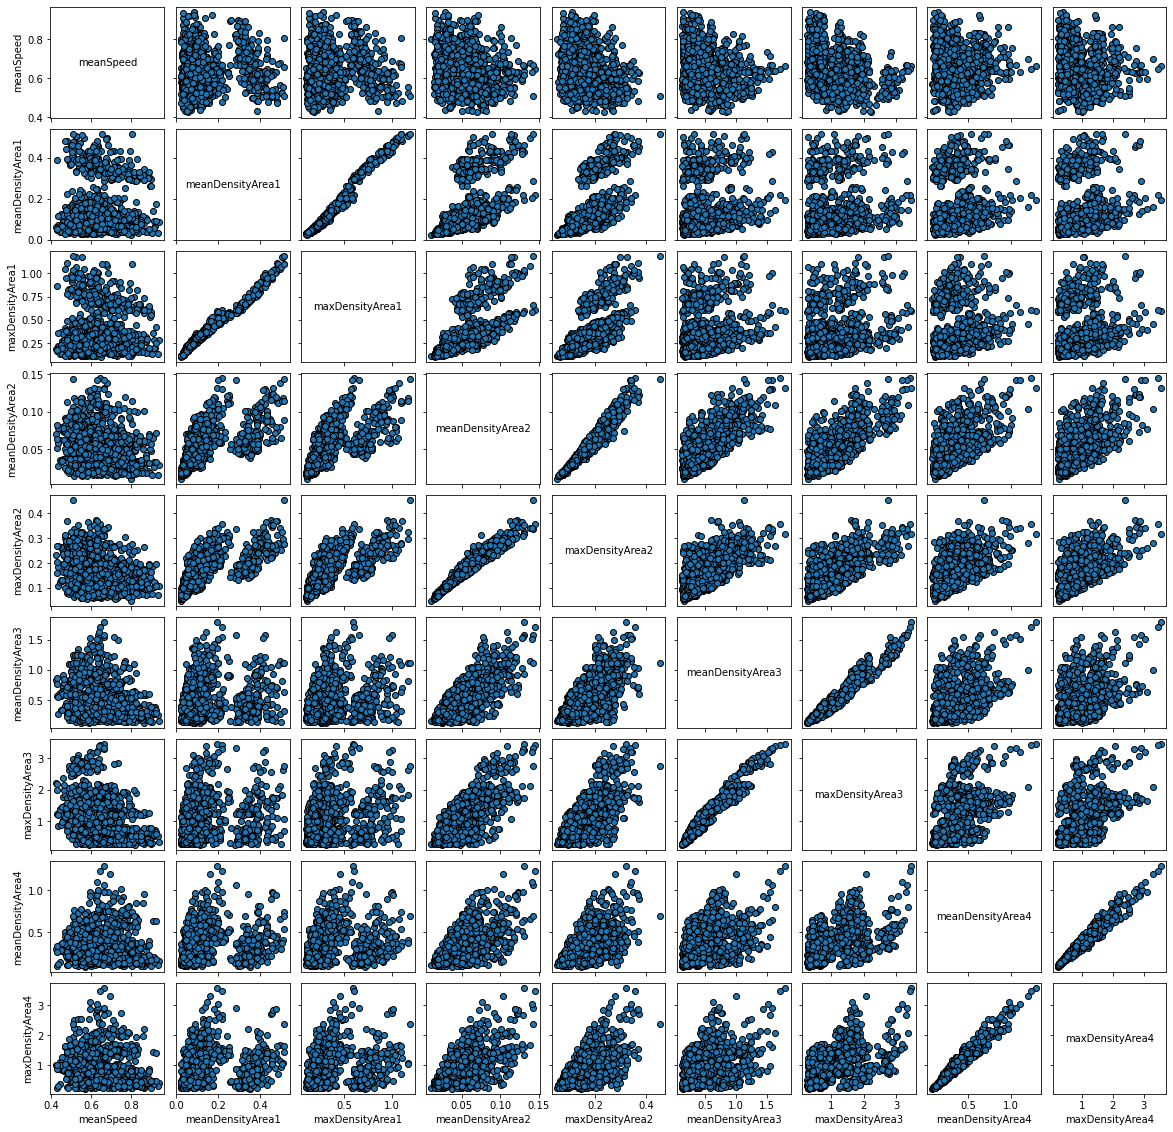

In [9]:
from ema_workbench.analysis import pairs_plotting

fig, axes = pairs_plotting.pairs_scatter(
    experiments,
    results,
)

fig.set_size_inches(20, 20)
plt.show()

## Linear regression model

In [10]:
import statsmodels.api as sm

# add constant
X_0 = sm.add_constant(X)

In [38]:
# specify outcome to fit linear regression on
outcome = 'meanSpeed'

In [39]:
est = sm.OLS(results_df[outcome], X_0.astype(float)).fit()
print(est.summary())
print(est.params)

                            OLS Regression Results                            
Dep. Variable:              meanSpeed   R-squared:                       0.899
Model:                            OLS   Adj. R-squared:                  0.898
Method:                 Least Squares   F-statistic:                     980.9
Date:                Wed, 27 Apr 2022   Prob (F-statistic):               0.00
Time:                        11:36:30   Log-Likelihood:                 2005.8
No. Observations:                1000   AIC:                            -3992.
Df Residuals:                     990   BIC:                            -3943.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.2256    

## Feature scoring

In [13]:
from ema_workbench.analysis import feature_scoring

# use the extra trees algorithm
fs = feature_scoring.get_feature_scores_all(
    x=X,
    y=results,
    alg='extra trees',
)

/home/tevito/anaconda3/envs/CrowdSim/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/home/tevito/anaconda3/envs/CrowdSim/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
<frozen importlib._bootstrap>:914: ImportWarning: ShimImporter.find_spec() not found; falling back to find_module()
/home/tevito/anaconda3/envs/CrowdSim/lib/python3.10/site-packages/ema_workbench-2.1.1-py3.10.egg/ema_workbench/analysis/feature_scoring.py:389: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  complete = complete.append(fs.T, sort=True)
/home/tevito/anaconda3/envs/CrowdSim/lib/python3.10/site-pack

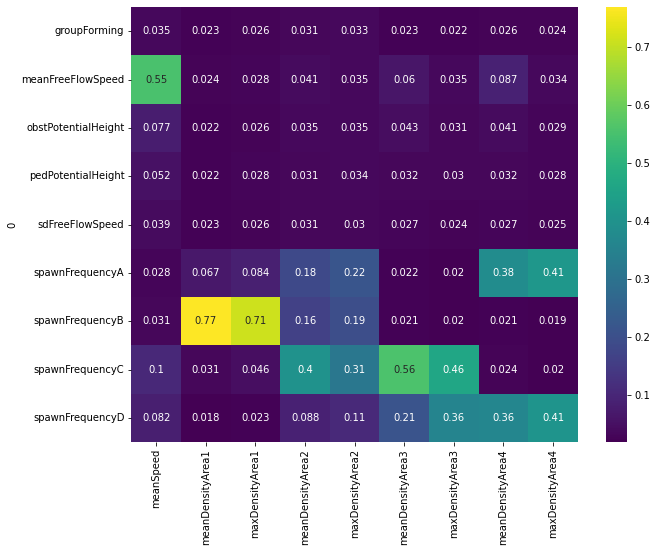

In [14]:
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(fs,
            cmap="viridis",
            annot=True,
            ax=ax)
plt.show()

In [59]:
from ema_workbench.analysis import RuleInductionType

x = experiments
y = (
    (results['maxDensityArea1'] > 0.99) | 
    (results['maxDensityArea2'] > 0.99) |
    (results['maxDensityArea3'] > 0.99) |
    (results['maxDensityArea4'] > 0.99)
)

fs, alg = feature_scoring.get_ex_feature_scores(
    x, y, mode=RuleInductionType.CLASSIFICATION
)
fs.sort_values(ascending=False, by=1)

,1
0,
spawnFrequencyD,0.373095
spawnFrequencyC,0.204247
spawnFrequencyA,0.185358
pedPotentialHeight,0.044019
obstPotentialHeight,0.043906
meanFreeFlowSpeed,0.040969
groupForming,0.040516
sdFreeFlowSpeed,0.036803
spawnFrequencyB,0.031088


## PRIM

In [42]:
x = experiments
y = (
    (results['meanSpeed'] < np.percentile(results['meanSpeed'], 10)) | 
    (results['meanDensityArea1'] > np.percentile(results['meanDensityArea1'], 90)) |
    (results['maxDensityArea1'] > 0.99) | 
    (results['meanDensityArea2'] > np.percentile(results['meanDensityArea2'], 90)) |
    (results['maxDensityArea2'] > 0.99) |
    (results['meanDensityArea3'] > np.percentile(results['meanDensityArea3'], 90)) |
    (results['maxDensityArea3'] > 0.99) |
    (results['meanDensityArea4'] > np.percentile(results['meanDensityArea4'], 90)) |
    (results['maxDensityArea4'] > 0.99)
)
prim_alg = prim.Prim(x, y, threshold=0.8)
box = prim_alg.find_box()

In [53]:
x = experiments
y = (
    (results['maxDensityArea1'] > 0.99) | 
    (results['maxDensityArea2'] > 0.99) |
    (results['maxDensityArea3'] > 0.99) |
    (results['maxDensityArea4'] > 0.99)
)
prim_alg = prim.Prim(x, y, threshold=0.8)
box = prim_alg.find_box()

In [54]:
sum(y)

637

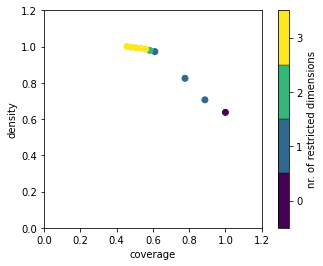

In [55]:
box.show_tradeoff()
plt.show()

In [56]:
chosen_point = 5

coverage    0.55887
density     0.98615
id                5
mass          0.361
mean        0.98615
res_dim           3
Name: 5, dtype: object

                       box 5                                           
                         min        max                       qp values
spawnFrequencyD     1.000000   2.500000  [-1.0, 4.7498664653296576e-61]
pedPotentialHeight  5.016708  47.759453      [-1.0, 0.2277586871204348]
meanFreeFlowSpeed   0.686896   1.159508      [0.2277586871204348, -1.0]



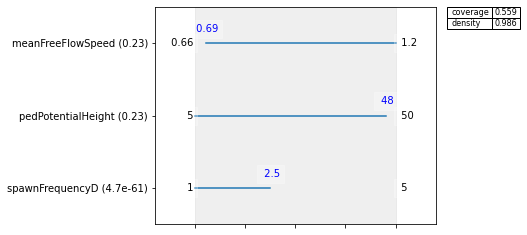

In [57]:
box.inspect(chosen_point)
box.inspect(chosen_point, style="graph")
plt.show()

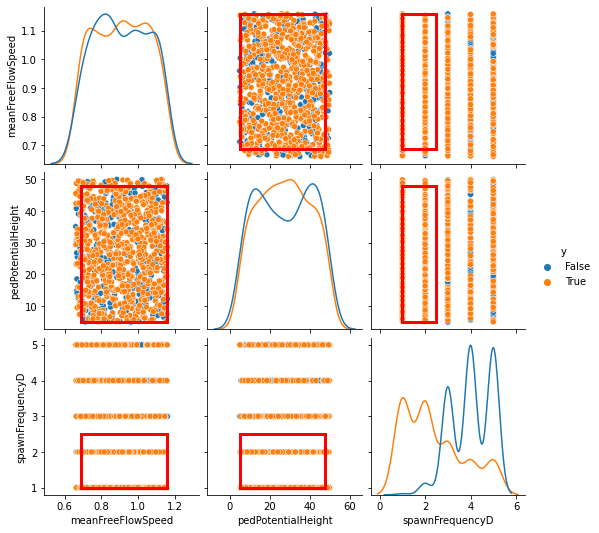

In [58]:
box.show_pairs_scatter(chosen_point)
plt.show()